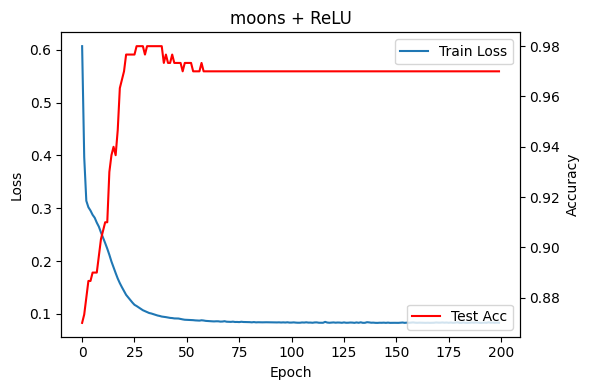

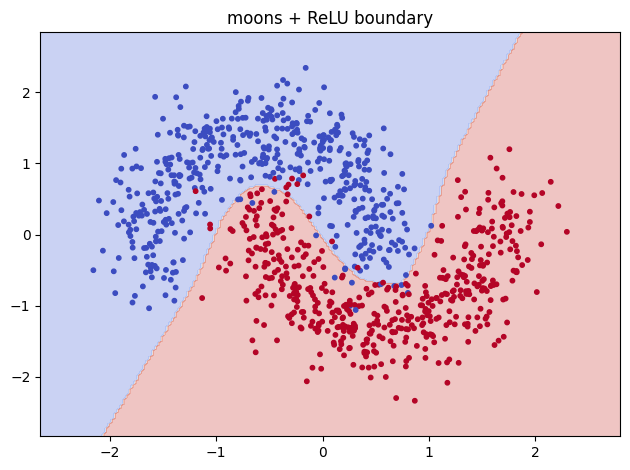

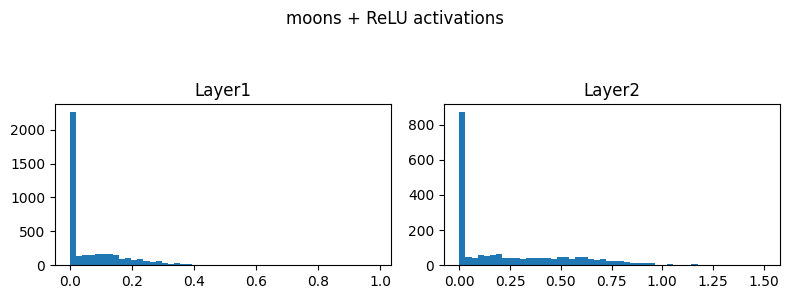

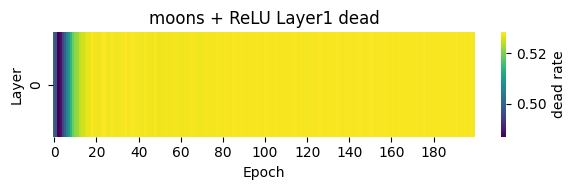

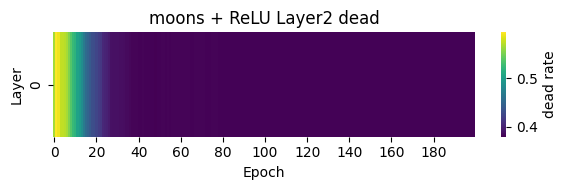

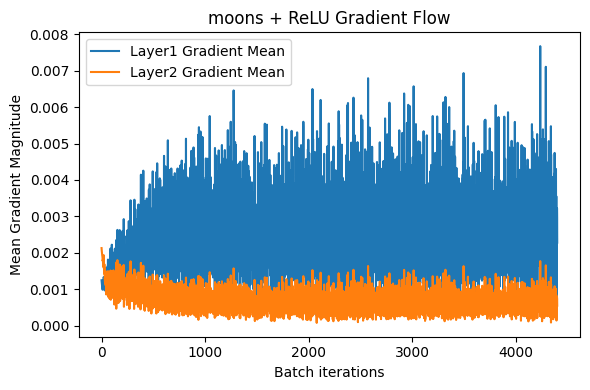

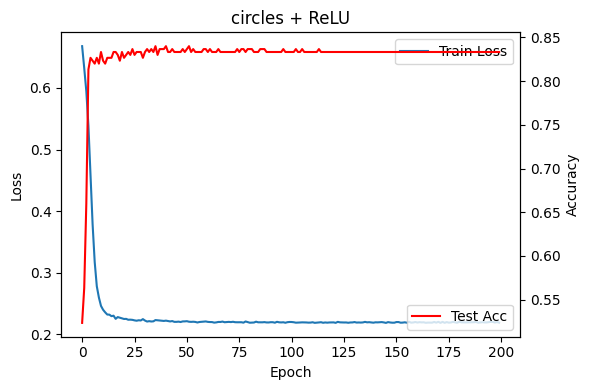

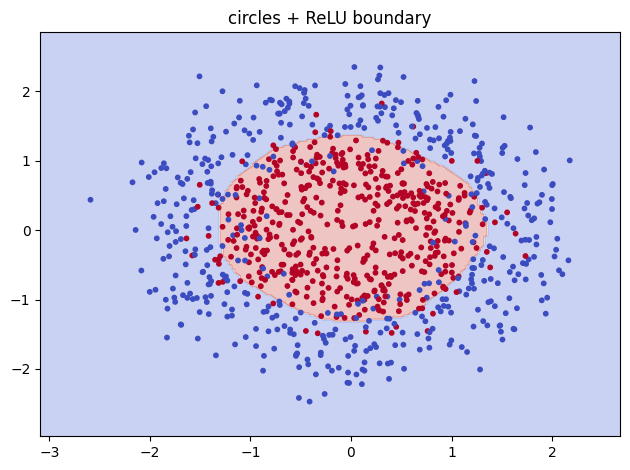

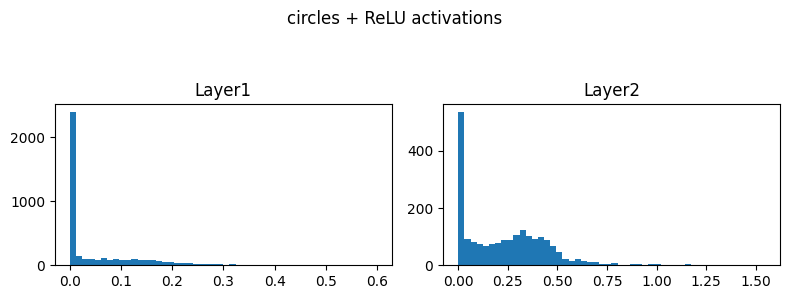

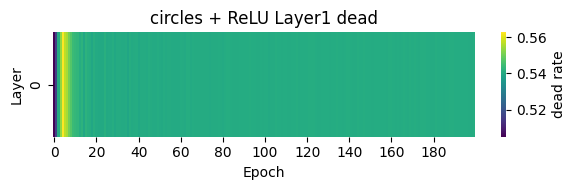

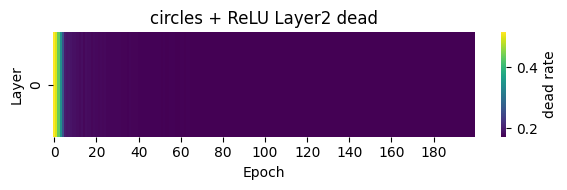

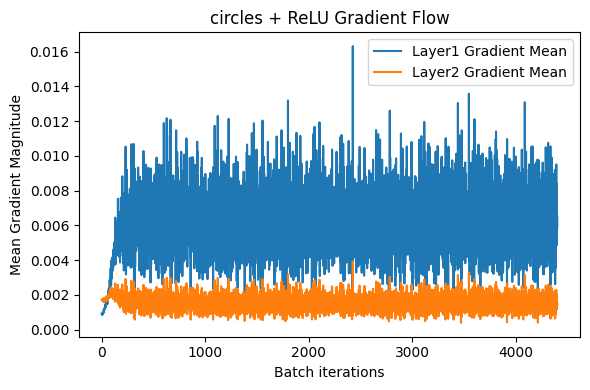

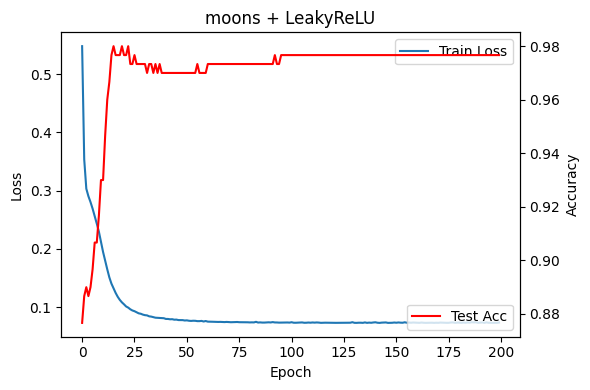

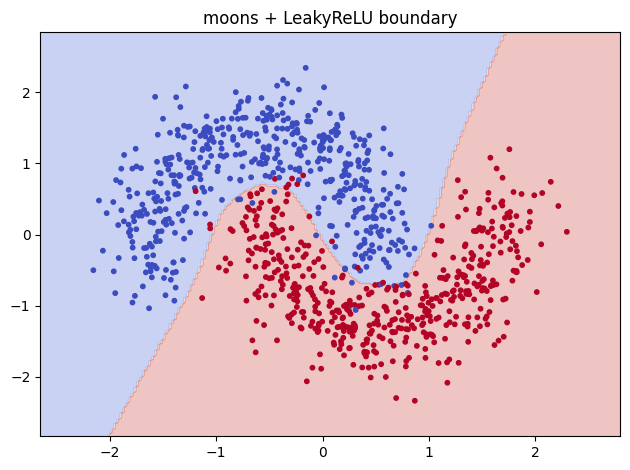

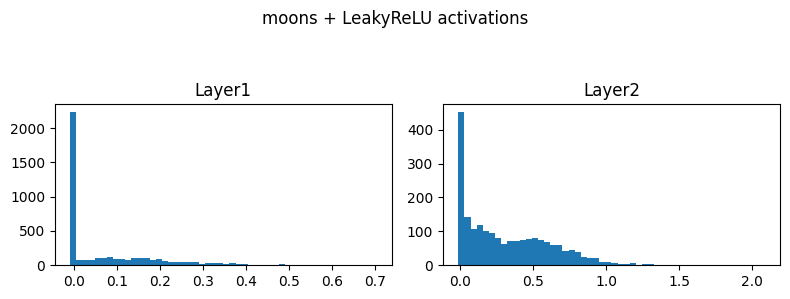

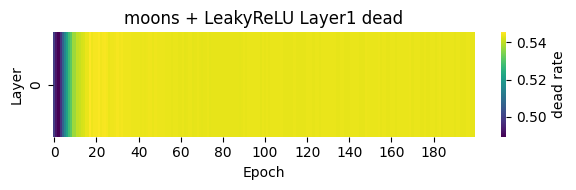

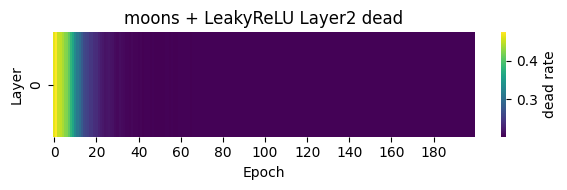

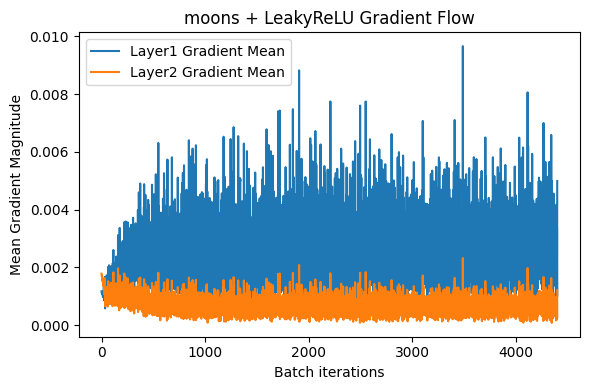

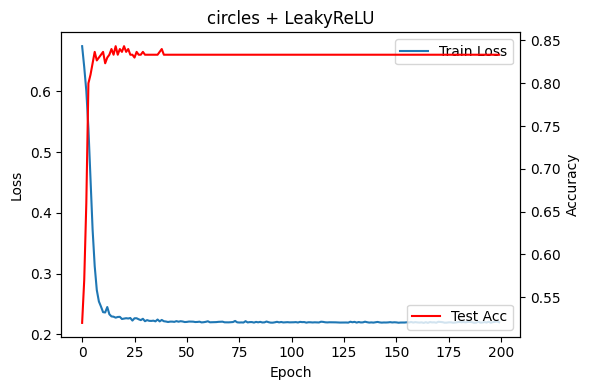

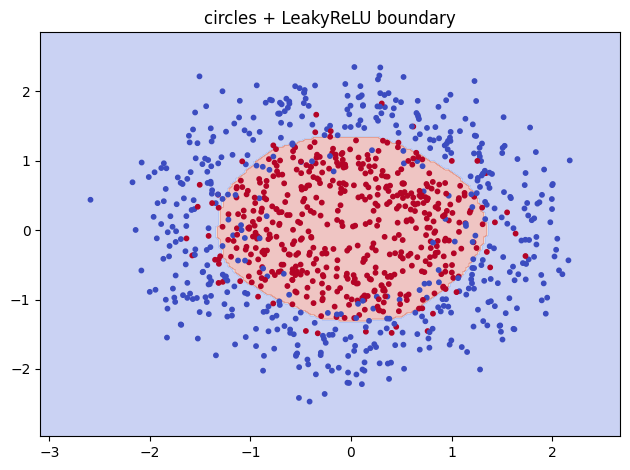

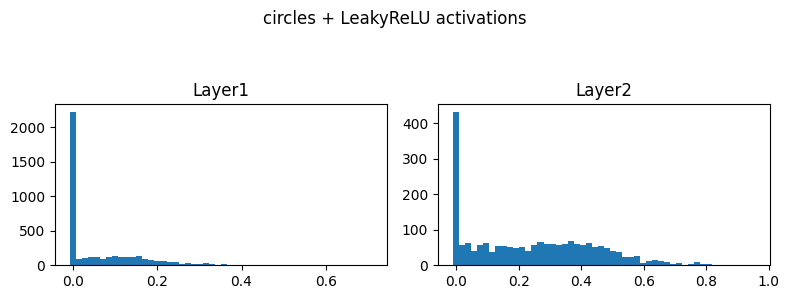

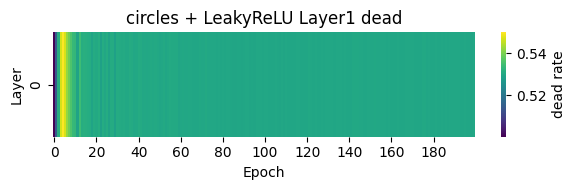

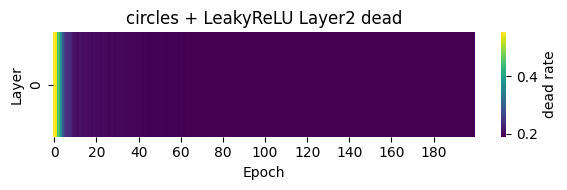

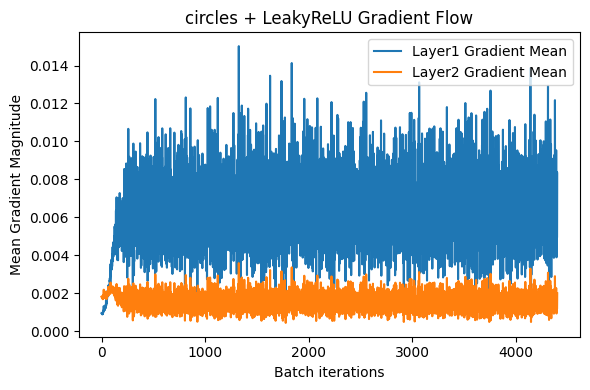

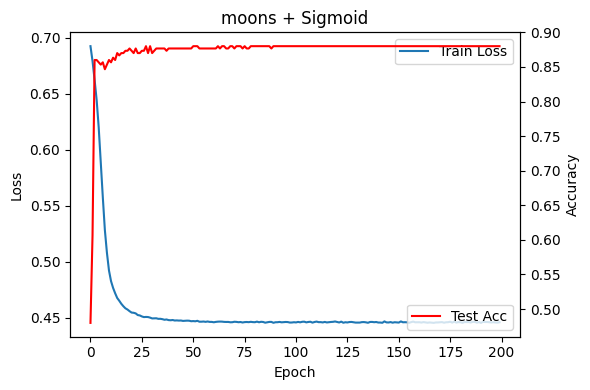

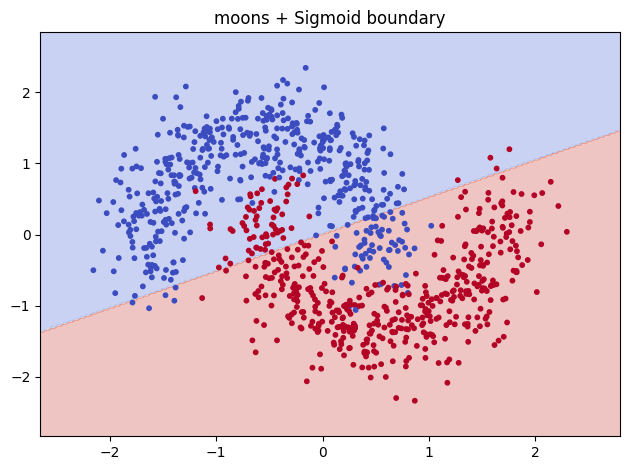

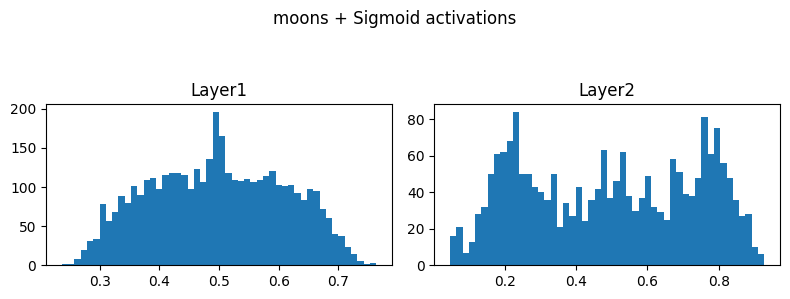

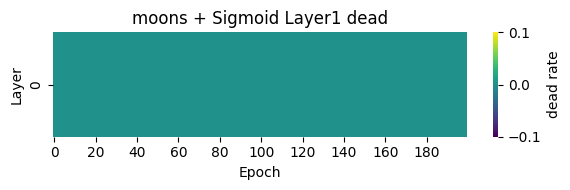

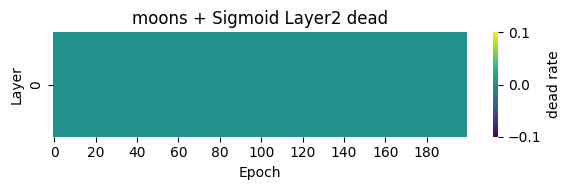

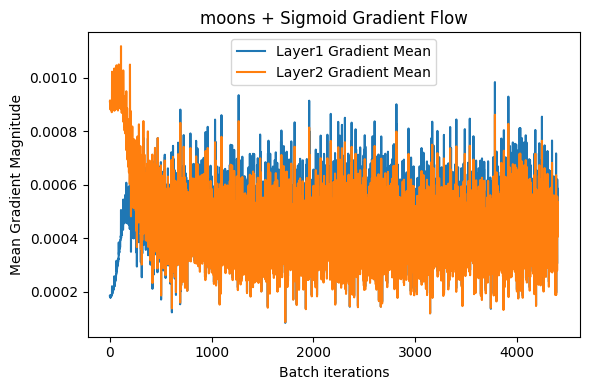

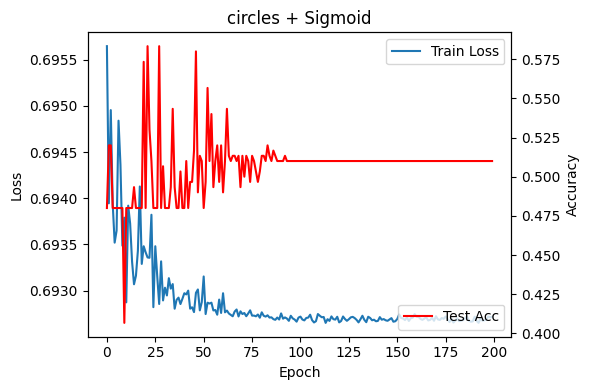

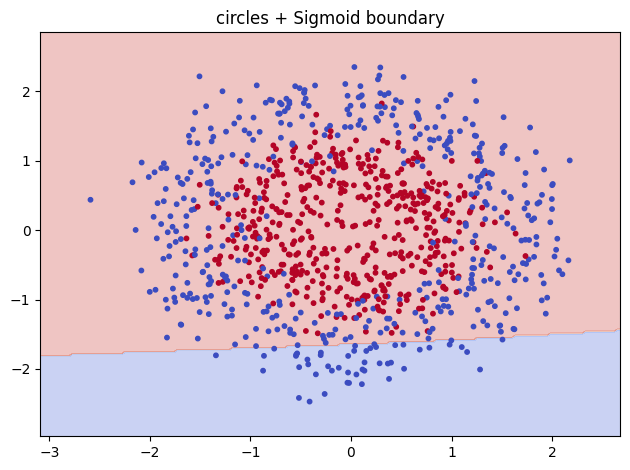

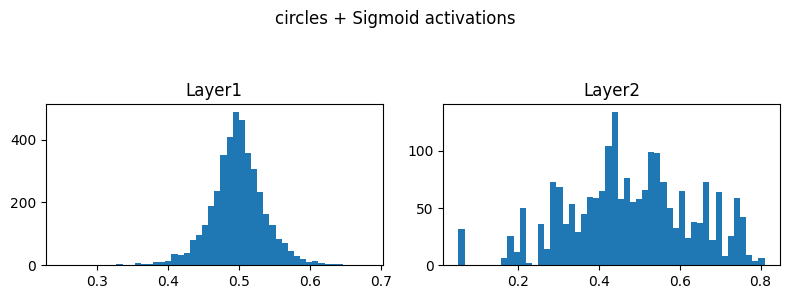

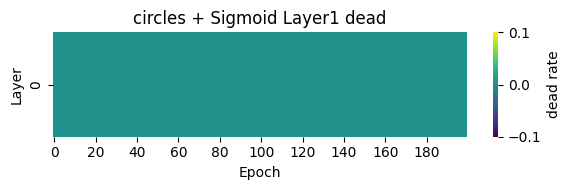

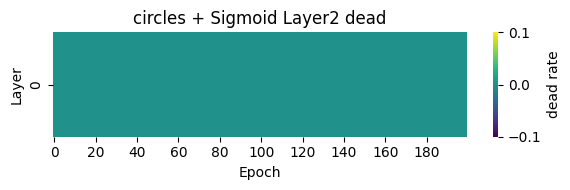

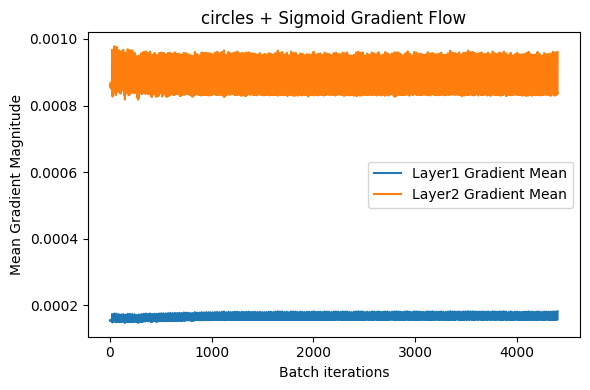

'\n실험 목적:\n- ReLU, LeakyReLU, Sigmoid 각각의 활성화 함수가 dead neuron, gradient 흐름, 학습 성능에 미치는 영향을 비교한다.\n- moons, circles 데이터셋에서 비선형 분류 문제를 해결하는 데 각 활성화 함수의 장단점을 시각적으로 확인한다.\n\n주요 실험 포인트:\n- dead neuron 비율이 높은 경우 학습이 잘 안 됨 (특히 ReLU)\n- LeakyReLU는 dead neuron 문제를 완화\n- Sigmoid는 dead neuron은 없지만 gradient가 소멸되어 깊은 네트워크에서 학습이 어려움\n'

In [1]:
!pip install seaborn

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# 하이퍼파라미터 설정
batch_size   = 32             # 한 번에 처리할 데이터 개수
num_epochs   = 200            # 전체 데이터셋을 몇 번 반복해서 학습할지
learning_rate= 0.001          # Adam에 적합한 학습률
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu") # GPU 사용 가능하면 GPU

# 데이터셋 생성 및 전처리 함수
def load_dataset(name):
    """
    moons 또는 circles 데이터셋을 생성하고, 표준화 후 DataLoader로 반환합니다.
    """
    if name == 'moons':
        X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
    else:
        X, y = make_circles(n_samples=1000, noise=0.2, factor=0.5, random_state=42)
    # 학습/테스트 데이터 분할 (7:3)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42)
    # 평균 0, 분산 1로 표준화
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test  = scaler.transform(X_test)
    # 텐서로 변환 후 DataLoader 생성
    train_ds = TensorDataset(torch.FloatTensor(X_train),
                             torch.LongTensor(y_train))
    test_ds  = TensorDataset(torch.FloatTensor(X_test),
                             torch.LongTensor(y_test))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)
    # 전체 데이터 반환(결정경계 시각화용)
    return train_loader, test_loader, np.vstack([X_train, X_test]), np.hstack([y_train, y_test])

# MLP 모델 정의
class MLP2D(nn.Module):
    """
    2D 입력을 받아 2개 클래스로 분류하는 다층 퍼셉트론 모델.
    활성화 함수는 실험마다 다르게 넣을 수 있음.
    Sigmoid 쓸 때는 출력층에 Softmax를 붙여서 CrossEntropyLoss와 호환.
    """
    def __init__(self, activation):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.act1 = activation
        self.fc2 = nn.Linear(128, 64)
        self.act2 = activation
        # Sigmoid 쓸 때는 Softmax 출력층 추가
        if isinstance(activation, nn.Sigmoid):
            self.fc3 = nn.Sequential(
                nn.Linear(64, 2),
                nn.Softmax(dim=1)
            )
        else:
            self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        # 순전파: 은닉층1 → 은닉층2 → 출력
        h1 = self.act1(self.fc1(x))
        h2 = self.act2(self.fc2(h1))
        return self.fc3(h2), h1, h2

# 학습 및 평가 함수
def train_and_evaluate(activation, train_loader, test_loader):
    """
    주어진 활성화 함수로 모델을 학습하고, dead neuron 비율과 gradient 흐름을 추적합니다.
    Adam 옵티마이저와 학습률 스케줄러 사용.
    """
    model = MLP2D(activation).to(device)
    # 가중치 초기화 (std=0.1로 dead neuron 완화)
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0, std=0.1)
            nn.init.zeros_(m.bias)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    loss_fn   = nn.CrossEntropyLoss()

    train_losses, test_accs = [], []
    dead1_rates, dead2_rates = [], []
    grad_hist1, grad_hist2 = [], []

    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        all_h1, all_h2 = [], []

        # 배치 단위로 학습
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            logits, h1, h2 = model(Xb)

            # backward에서 gradient 추적 (각 배치마다 평균)
            h1.register_hook(lambda grad: grad_hist1.append(grad.abs().mean().item()))
            h2.register_hook(lambda grad: grad_hist2.append(grad.abs().mean().item()))

            loss = loss_fn(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # dead neuron 비율 계산용 (배치별로 저장)
            all_h1.append(h1.detach().cpu())
            all_h2.append(h2.detach().cpu())

        # dead neuron 비율: epoch 전체 평균
        epoch_dead1 = np.mean([(h.numpy() <= 0).mean() for h in all_h1])
        epoch_dead2 = np.mean([(h.numpy() <= 0).mean() for h in all_h2])
        dead1_rates.append(epoch_dead1)
        dead2_rates.append(epoch_dead2)
        train_losses.append(running_loss/len(train_loader))
        scheduler.step()

        # 평가 (test set 정확도 측정)
        model.eval()
        correct = 0
        total   = 0
        with torch.no_grad():
            for Xb, yb in test_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                pred = model(Xb)[0].argmax(dim=1)
                correct += (pred==yb).sum().item()
                total   += yb.size(0)
        test_accs.append(correct/total)

    # 학습 곡선, dead neuron, gradient 정보, 모델 반환
    return train_losses, test_accs, dead1_rates, dead2_rates, grad_hist1, grad_hist2, model

# 시각화 함수들
def plot_loss_acc(losses, accs, title):
    # 학습 손실 및 정확도 곡선
    fig, ax1 = plt.subplots(figsize=(6,4))
    ax2 = ax1.twinx()
    ax1.plot(losses, '-', label='Train Loss')
    ax2.plot(accs, 'r-', label='Test Acc')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    ax1.set_title(title)
    ax1.legend(loc='upper right'); ax2.legend(loc='lower right')
    fig.tight_layout()
    plt.show()

def plot_decision_boundary(model, X_all, y_all, title):
    # 결정 경계 시각화
    xx,yy = np.meshgrid(
        np.linspace(X_all[:,0].min()-0.5, X_all[:,0].max()+0.5, 200),
        np.linspace(X_all[:,1].min()-0.5, X_all[:,1].max()+0.5, 200))
    grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()]).to(device)
    Z = model(grid)[0].argmax(dim=1).cpu().numpy().reshape(xx.shape)
    plt.contourf(xx,yy,Z,alpha=0.3,cmap='coolwarm')
    plt.scatter(X_all[:,0],X_all[:,1],c=y_all,s=10,cmap='coolwarm')
    plt.title(title); plt.tight_layout(); plt.show()

def plot_activation_hist(h1, h2, title):
    # 은닉층 활성화 분포
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1); plt.hist(h1.ravel(), bins=50); plt.title('Layer1')
    plt.subplot(1,2,2); plt.hist(h2.ravel(), bins=50); plt.title('Layer2')
    plt.suptitle(title); plt.tight_layout(rect=[0,0,1,0.9]); plt.show()

def plot_dead_heatmap(dead_rates, title):
    # dead neuron 비율 히트맵 (레이어별 dead rate)
    arr = np.array(dead_rates).reshape(-1, 1).T  # (epochs, 1) → (1, epochs)
    plt.figure(figsize=(6,2))
    sns.heatmap(arr, cmap='viridis', cbar_kws={'label':'dead rate'}, xticklabels=20)
    plt.xlabel('Epoch'); plt.ylabel('Layer')
    plt.title(title); plt.tight_layout(); plt.show()

def plot_gradient_flow(grad_hist1, grad_hist2, title):
    # gradient 흐름 시각화 (레이어별)
    plt.figure(figsize=(6,4))
    plt.plot(grad_hist1, label='Layer1 Gradient Mean')
    plt.plot(grad_hist2, label='Layer2 Gradient Mean')
    plt.title(title)
    plt.xlabel('Batch iterations')
    plt.ylabel('Mean Gradient Magnitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 실험 실행 (moons, circles, 각 활성화 함수별)
for name, act in [('ReLU',nn.ReLU()),('LeakyReLU',nn.LeakyReLU(0.01)),('Sigmoid',nn.Sigmoid())]:
    for ds in ['moons','circles']:
        # 데이터셋 준비
        tr, te, X_all, y_all = load_dataset(ds)
        # 모델 학습 및 dead neuron/gradient 추적
        losses, accs, d1, d2, gh1, gh2, model = train_and_evaluate(act, tr, te)

        # 학습 손실/정확도 곡선 시각화
        plot_loss_acc(losses, accs, f'{ds} + {name}')
        # 결정경계 시각화
        plot_decision_boundary(model, X_all, y_all, f'{ds} + {name} boundary')

        # 마지막 배치의 은닉층 활성화 분포 확인
        with torch.no_grad():
            xb, _ = next(iter(tr))
            h1, h2 = model(xb.to(device))[1:]
        plot_activation_hist(h1.cpu().numpy(), h2.cpu().numpy(), f'{ds} + {name} activations')

        # dead neuron 비율 히트맵
        plot_dead_heatmap(d1, f'{ds} + {name} Layer1 dead')
        plot_dead_heatmap(d2, f'{ds} + {name} Layer2 dead')

        # gradient 흐름 시각화
        plot_gradient_flow(gh1, gh2, f'{ds} + {name} Gradient Flow')

"""
실험 목적:
- ReLU, LeakyReLU, Sigmoid 각각의 활성화 함수가 dead neuron, gradient 흐름, 학습 성능에 미치는 영향을 비교한다.
- moons, circles 데이터셋에서 비선형 분류 문제를 해결하는 데 각 활성화 함수의 장단점을 시각적으로 확인한다.

주요 실험 포인트:
- dead neuron 비율이 높은 경우 학습이 잘 안 됨 (특히 ReLU)
- LeakyReLU는 dead neuron 문제를 완화
- Sigmoid는 dead neuron은 없지만 gradient가 소멸되어 깊은 네트워크에서 학습이 어려움
"""
